# Turing Machines

This module encodes non-deterministic Turing Machines with a doubly-infinite tape (call it the "dub TM" :-) ). We begin with a tape containing exactly the given input and let the computation begin facing the left-end of the given input string.

The given input string could be empty (epsilon). This situation translates to the TM's initial head facing a sea of blanks on the tape -- both to its left and to its right. No amount of "sniff-check" will let you sniff anything other than a sea (of blanks).

Each attempt to ``fall off either end of the tape'' is met with an allocation of some number (currently 8) of extra blank characters. Halting configurations as well as paths leading to them are maintained. All executions are bounded by a constant __fuel__ that the user can progressively increase till the desired acceptances are seen (or the user surmises nontermination). This is like the gas in your tank! When you run out of gas, you are forced to halt.

We maintain nsteps as remaining "fuel" per thread (non-deterministic) of execution. When a thread runs out of fuel, it stops running. A run ends with a printout of the terminal configurations plus the fuel remaining per thread. This is ideal from the point of explaining nondeterministic runtimes. We elaborate now.

An NDTM accepts a string in nondeterminstic polynomial time (NP) if there is an accepting computational history of polynomial length. In our NDTM simulation, you'll see the remaining fuel per thread. Any thread with the least fuel consumption and still accepts is the one we go by in measuring runtimes!

In [1]:
from Imports.SystemImports       import *
from Imports.DotBashers          import *
from Imports.TransitionSelectors import *

# Turing Machines

## Basic Definitions

Turing Machines are structures 

  $(Q, Sigma, Gamma, Delta, q0, B, F)$
  
where

 * $Q$       : Finite non-empty set of states

 * $Sigma$   : Finite non-empty input alphabet

 * $Gamma$   : Finite non-empty tape alphabet (subsumes Sigma, so that the user-given input can be written on the tape; also, $Gamma$ always includes $B$, representing an empty space (``blank'') on the tape).
 
   - Computations are set up by writing the user-given input on the tape
   
   - The portion of the tape before and after the user input is filled with an infinite **sea of blanks** (we allocate it on demand).
   
       - Note: In our TMs, the blank character 
       is user-selectable. The preferred 
         blank symbol is "." (dot).

 * $Delta$   : A transition function that takes a state, a current tape
 symbol being scanned

$Delta$'s signature is
       
$(Q \times Gamma) \rightarrow P(Q \times Gamma \times \{L,R,S\} )$

This means that the TM, in state q, while scanning tape symbol s will choose one of the (q1, g, Dir) tripes. Here, q1 is the next control state, is the new tape symbol that replaces what's being looked at, and Dir is one of Left, Right, or Same, encoded by "L", "R", or "S". 

A TM is ``stuck'' if it cannot fire __any__ transition from a given configuration. Such terminal configurations are halting configurations with a __reject__ status. All final states are also terminal configurations with an __accept__ status.
 

# Computation wrt Instantaneous Descriptions (ID)

Let us define the transition function (transition table) as follows:

* { (q, g) : { (q1, g1, D1), (q2, g2, D2), ... }

An ID of a TM is, mathematically, a triple

     (q, tape, position-of-tape-being-ogled-at)
 
For our (more practical) TM, the ID is a quadruple

     (q, hi, tape, fuel)
    
where 

- q is the present control state of the TM,

- hi is the head index (into the tape, 
treating index=0 as the leftmost position of the tape).

- tape is the string that constitutes the tape, and

- fuel is the amount of "fuel" (computational steps) left
  for this ID. 
  
    - Note that  when we split IDs, we convey the same
      amount of remaining fuel to the threads being spawned.

 

Examples now follow, and they will drive home these ideas.


 Consistency checker(s) for TM have gone to DotBashers

# Example DTM: accepts "w#w"

This TM is made deterministic by going to exactly one new ID (the set of next states in the transition table has a cardinality of one). We will enter the TM (called wpw) and use dotObj_tm to plot it.

In [2]:
# Example TM that recognizes w#w. We use "." to denote blanks.
# Blanks are of course user-selectable
wpw = {
 "Q": {"q0","q1","q2","q3","q4","q5","q6","q7","q8","q9","q10"},
 "Sigma" : {'0','1'},
 "Gamma" : {'0','1','X','Y','#','.'},
 "Delta" : {  
     ("q0","0") : { ("q1","X","R")},
     ("q0","#") : { ("q5","#","R")},
     ("q0","1") : { ("q7","Y","R")},
     #
     ("q1","0") : { ("q1","0","R")},     
     ("q1","1") : { ("q1","1","R")},
     ("q1","#") : { ("q2","#","R")},
     #
     ("q2","X") : { ("q2","X","R")},
     ("q2","Y") : { ("q2","Y","R")},     
     ("q2","0") : { ("q3","X","L")},
     #
     ("q3","X") : { ("q3","X","L")},  
     ("q3","Y") : { ("q3","Y","L")},
     ("q3","#") : { ("q4","#","L")}, 
     #
     ("q4","0") : { ("q4","0","L")},
     ("q4","1") : { ("q4","1","L")},     
     ("q4","X") : { ("q0","X","R")},
     ("q4","Y") : { ("q0","Y","R")},
     #
     ("q5","X") : { ("q5","X","R")},     
     ("q5","Y") : { ("q5","Y","R")},
     ("q5",".") : { ("q6",".","R")},  
     #
     ("q7","0") : { ("q7","0","R")},
     ("q7","1") : { ("q7","1","R")},     
     ("q7","#") : { ("q8","#","R")},
     #
     ("q8","X") : { ("q8","X","R")},     
     ("q8","Y") : { ("q8","Y","R")},
     ("q8","1") : { ("q9","Y","L")}, 
     #
     ("q9","X") : { ("q9","X","L")},     
     ("q9","Y") : { ("q9","Y","L")},
     ("q9","#") : { ("q10","#","L")},  
     #
     ("q10","0") : { ("q10","0","L")},     
     ("q10","1") : { ("q10","1","L")},
     ("q10","X") : { ("q0","X","R")},
     ("q10","Y") : { ("q0","Y","R")},
 },
 "q0"    : "q0",
 "B"     : '.',
 "F"     : {"q6"}
}

In [3]:
wpw

{'B': '.',
 'Delta': {('q0', '#'): {('q5', '#', 'R')},
  ('q0', '0'): {('q1', 'X', 'R')},
  ('q0', '1'): {('q7', 'Y', 'R')},
  ('q1', '#'): {('q2', '#', 'R')},
  ('q1', '0'): {('q1', '0', 'R')},
  ('q1', '1'): {('q1', '1', 'R')},
  ('q10', '0'): {('q10', '0', 'L')},
  ('q10', '1'): {('q10', '1', 'L')},
  ('q10', 'X'): {('q0', 'X', 'R')},
  ('q10', 'Y'): {('q0', 'Y', 'R')},
  ('q2', '0'): {('q3', 'X', 'L')},
  ('q2', 'X'): {('q2', 'X', 'R')},
  ('q2', 'Y'): {('q2', 'Y', 'R')},
  ('q3', '#'): {('q4', '#', 'L')},
  ('q3', 'X'): {('q3', 'X', 'L')},
  ('q3', 'Y'): {('q3', 'Y', 'L')},
  ('q4', '0'): {('q4', '0', 'L')},
  ('q4', '1'): {('q4', '1', 'L')},
  ('q4', 'X'): {('q0', 'X', 'R')},
  ('q4', 'Y'): {('q0', 'Y', 'R')},
  ('q5', '.'): {('q6', '.', 'R')},
  ('q5', 'X'): {('q5', 'X', 'R')},
  ('q5', 'Y'): {('q5', 'Y', 'R')},
  ('q7', '#'): {('q8', '#', 'R')},
  ('q7', '0'): {('q7', '0', 'R')},
  ('q7', '1'): {('q7', '1', 'R')},
  ('q8', '1'): {('q9', 'Y', 'L')},
  ('q8', 'X'): {('q8', 'X', '

In [4]:
wpwobj = dotObj_tm(wpw)

In [5]:
wwndtm = {
 "Q": {"q0","q1","q2","q3","q4","q5","q6","q7","q8","q9","q10",
       "q11","q12","q13","q14"},
 "Sigma" : {'0','1'},
 "Gamma" : {'0','1','X','Y','2','3',
            'P','Q','.'},
 "Delta" : {  
     ("q0",".") : { ("q1",".","R")},
     ("q0","0") : { ("q14","0","S")},
     ("q0","1") : { ("q14","1","S")},
     #
     ("q14","0") : { ("q14","0","R"), ('q2','X','L')},
     ("q14","1") : { ("q14","1","R"), ('q2','Y','L')},
     #
     ("q2","0") : { ("q2","0","L")},
     ("q2","1") : { ("q2","1","L")},     
     ("q2",".") : { ("q3",".","R")},
     #
     ("q3","X") : { ("q6","X","R")},  
     ("q3","Y") : { ("q7","Y","R")},
     #
     ("q3","0") : { ("q4","P","R")},
     ("q3","1") : { ("q5","Q","R")},          
     #
     ("q3","2") : { ("q12","2","R")},
     ("q3","3") : { ("q12","3","R")},
     #
     #--
     ("q4","0") : { ("q4","0","R")},
     ("q4","1") : { ("q4","1","R")},
     ("q4","2") : { ("q4","2","R")},
     ("q4","3") : { ("q4","3","R")},
     ("q4","X") : { ("q10","2","R")},     
     #
     ("q5","0") : { ("q5","0","R")},
     ("q5","1") : { ("q5","1","R")},
     ("q5","2") : { ("q5","2","R")},
     ("q5","3") : { ("q5","3","R")},
     ("q5","Y") : { ("q11","3","R")},     
     #     
     ("q10","0") : { ("q8","X","L")},     
     ("q10","1") : { ("q8","Y","L")},
     ("q10",".") : { ("q8",".","L")},
     #     
     ("q11","0") : { ("q9","X","L")},     
     ("q11","1") : { ("q9","Y","L")},
     ("q11",".") : { ("q9",".","L")},     
     #
     ("q8","0") : { ("q8","0","L")},     
     ("q8","1") : { ("q8","1","L")},
     ("q8","2") : { ("q8","2","L")},
     ("q8","3") : { ("q8","3","L")},
     ("q8","P") : { ("q3","P","R")},
     #
     ("q9","0") : { ("q9","0","L")},     
     ("q9","1") : { ("q9","1","L")},
     ("q9","2") : { ("q9","2","L")},
     ("q9","3") : { ("q9","3","L")},
     ("q9","Q") : { ("q3","Q","R")},
     #
     ("q12","2") : { ("q12","2","R")},
     ("q12","3") : { ("q12","3","R")},
     ("q12",".") : { ("q13",".","R")}
 },
 "q0"    : "q0",
 "B"     : '.',
 "F"     : {"q1","q13"}
}


In [6]:
wpwobj.source

'// TO_St1\ndigraph {\n\tgraph [rankdir=LR]\n\t\tEMPTY [label="" shape=plaintext]\n\t\tq3 [label=q3 peripheries=1 shape=circle]\n\t\tq4 [label=q4 peripheries=1 shape=circle]\n\t\tq5 [label=q5 peripheries=1 shape=circle]\n\t\tq2 [label=q2 peripheries=1 shape=circle]\n\t\tq9 [label=q9 peripheries=1 shape=circle]\n\t\tq1 [label=q1 peripheries=1 shape=circle]\n\t\tq7 [label=q7 peripheries=1 shape=circle]\n\t\tq0 [label=q0 peripheries=1 shape=circle]\n\t\tq10 [label=q10 peripheries=1 shape=circle]\n\t\tq8 [label=q8 peripheries=1 shape=circle]\n\t\tq6 [label=q6 peripheries=2 shape=circle]\n\t\t\tEMPTY -> q0\n\t\t\tq0 -> q1 [label="0 ; X,R"]\n\t\t\tq0 -> q5 [label="# ; #,R"]\n\t\t\tq0 -> q7 [label="1 ; Y,R"]\n\t\t\tq1 -> q1 [label="0 ; 0,R"]\n\t\t\tq1 -> q1 [label="1 ; 1,R"]\n\t\t\tq1 -> q2 [label="# ; #,R"]\n\t\t\tq2 -> q2 [label="X ; X,R"]\n\t\t\tq2 -> q2 [label="Y ; Y,R"]\n\t\t\tq2 -> q3 [label="0 ; X,L"]\n\t\t\tq3 -> q3 [label="X ; X,L"]\n\t\t\tq3 -> q3 [label="Y ; Y,L"]\n\t\t\tq3 -> q4 [

In [7]:
 TAPE_ALLOC_SIZE = 8
def step_tm(T, q_hi_tape_fuel, path, haltList):
    """Inputs: * A TM T
               * An ID -- a tuple q_hi_tape_fuel capturing
               - q:  the present state of the TM
               - hi: the head index that is initialized to 0.
               - tape: The full string representing the tape. 
                 tape[0] is the element at the leftmost position.
               - fuel: The amount of fuel left in this thread.
                 When an NDTM splits, it imparts the currently
                 remaining amount of fuel to all the progeny 
                 threads.
               * A path that leads to q_hi_tape_fuel
               * A haltList of halting configurations that 
                 builds up. Each halting config kept with path
                 leading to it.
       Output: A pair (l_id_path, nhaltList)
               * l_id_path is a list  
                  [ ((nq, nhi, ntape, nfuel), npath) ]   
                where (nq, nhi, ntape, nfuel) is the new ID 
                and npath is the extended path reaching it.
               * nhaltList is the extended halting config list.
       Detail: When the head is about to fall off either end, we 
               allocate TAPE_ALLOC_SIZE blank characters, thus keeping
               the head on the tape.
    """ 
    (q, hi, tape, fuel) = q_hi_tape_fuel
    extpath             = path + [q_hi_tape_fuel]
    nl_id_path          = []
    
    if (hi == len(tape)):
        # Going beyond end of allocated tape; allocate more!
        print("Allocating ", TAPE_ALLOC_SIZE, " tape cells to the RIGHT!")
        tape = tape + T["B"]*TAPE_ALLOC_SIZE
        
    if (q, tape[hi]) not in T["Delta"]:
        # No move on (q, tape[hi]), so record halt lset; return
        return (nl_id_path, haltList + [(q_hi_tape_fuel, path)])
               
    l_nq_ng_dirn      = T["Delta"][(q, tape[hi])] 
    
    for nq_ng_dirn in l_nq_ng_dirn:
        (nq, ng, dirn) = nq_ng_dirn
        # Head attempts to move to the left of the left-end
        if (hi==0) and (dirn=="L"):
            print("Allocating ", TAPE_ALLOC_SIZE, " tape cells to the LEFT!")
            ntape = T["B"]*TAPE_ALLOC_SIZE + ng + tape[1:]  
            nhi   = TAPE_ALLOC_SIZE - 1  # Do the left move too!
        else:
            ntape = tape[0:hi] +  ng  + tape[hi+1:len(tape)]
            nhi = (hi+1 if dirn=="R"
                   else ((hi-1) if dirn=="L" 
                         else (hi if dirn=="S"
                              else print("Illegal direction!"))))
           
        if (fuel > 0):
            nl_id_path += [((nq, nhi, ntape, fuel-1), extpath)]
                
    return (nl_id_path, haltList)

 
       

In [8]:
step_tm(wpw, ("q0",0,"0#1", 3), [], set({}))

([(('q1', 1, 'X#1', 2), [('q0', 0, '0#1', 3)])], set())

In [9]:
step_tm(wwndtm, ("q14",0, "00", 100), [], set({}))

Allocating  8  tape cells to the LEFT!


([(('q14', 1, '00', 99), [('q14', 0, '00', 100)]),
  (('q2', 7, '........X0', 99), [('q14', 0, '00', 100)])],
 set())

# Routines to run TM

We now devise a routine to run an NDTM.

In [10]:
def run_tm(T, tape, fuel):
    """Given a TM T and a tape, run the TM for fuel steps
       (e.g., gallons of gas in your tank), 
       collecting all halting configurations. 
       
       Return a triple
       (id_path_pairs, haltSet, nfuel) of
        - all resulting id_path_pairs 
        - the final haltSet
        - the remaining fuel
       This way, one can find all accepting and rejecting 
       IDs in the final haltSet and print paths to them.
    """
    q_hi_tape_fuel = (T["q0"], 0, tape, fuel)
    path         = []
    l_id_path    = [ (q_hi_tape_fuel, path) ]
    haltList     = [ ]
    l_trunc_path = [] # List of truncated paths
    
    while (l_id_path != []):
        (q_hi_tape_fuel, path)  = l_id_path[0] 
        (nq, nhi, ntape, nfuel) = q_hi_tape_fuel
        if (nfuel > 0):
            (nl_id_path, haltList) = step_tm(T, q_hi_tape_fuel, 
                                             path, haltList)
            l_id_path = nl_id_path + l_id_path[1:]
        else:
            l_trunc_path += [path]
            l_id_path = l_id_path[1:]
    
    return (l_trunc_path, haltList)


In [11]:
def explore_tm(T, tape, nsteps):
    """A handy routine to print the result of run_tm plus making 
       future extensions to explore run-results.
    """
    (l_trunc_path, haltList) = run_tm(T, tape, nsteps)
    if (haltList == []):
        print("TM hasn't halted.")
        print("The truncated paths so far are as follows.")
        for trunc_path in l_trunc_path:
            print(trunc_path)
    else:
        if (l_trunc_path != []):
            print("There are still ", len(l_trunc_path), "truncated paths.")
        print("Detailing the halted configs now.")
        
        for (haltConfig, path) in haltList:
            (haltState, head, tape, fuel) = haltConfig
            if (haltState in T["F"]):
                print("Accepted at ", haltConfig)
            else:
                print("Rejected at ", haltConfig)
            print(" via .. ")
            for id in path:
                print(" ->", end="")
                print(id)
            print(" ->", end="")
            print(haltConfig)
   

In [12]:
run_tm(wpw, "01#01..", 19)

([],
 [(('q6', 6, 'XY#XY..', 1),
   [('q0', 0, '01#01..', 19),
    ('q1', 1, 'X1#01..', 18),
    ('q1', 2, 'X1#01..', 17),
    ('q2', 3, 'X1#01..', 16),
    ('q3', 2, 'X1#X1..', 15),
    ('q4', 1, 'X1#X1..', 14),
    ('q4', 0, 'X1#X1..', 13),
    ('q0', 1, 'X1#X1..', 12),
    ('q7', 2, 'XY#X1..', 11),
    ('q8', 3, 'XY#X1..', 10),
    ('q8', 4, 'XY#X1..', 9),
    ('q9', 3, 'XY#XY..', 8),
    ('q9', 2, 'XY#XY..', 7),
    ('q10', 1, 'XY#XY..', 6),
    ('q0', 2, 'XY#XY..', 5),
    ('q5', 3, 'XY#XY..', 4),
    ('q5', 4, 'XY#XY..', 3),
    ('q5', 5, 'XY#XY..', 2)])])

In [13]:
explore_tm(wpw, "01#01..", 19)

Detailing the halted configs now.
Accepted at  ('q6', 6, 'XY#XY..', 1)
 via .. 
 ->('q0', 0, '01#01..', 19)
 ->('q1', 1, 'X1#01..', 18)
 ->('q1', 2, 'X1#01..', 17)
 ->('q2', 3, 'X1#01..', 16)
 ->('q3', 2, 'X1#X1..', 15)
 ->('q4', 1, 'X1#X1..', 14)
 ->('q4', 0, 'X1#X1..', 13)
 ->('q0', 1, 'X1#X1..', 12)
 ->('q7', 2, 'XY#X1..', 11)
 ->('q8', 3, 'XY#X1..', 10)
 ->('q8', 4, 'XY#X1..', 9)
 ->('q9', 3, 'XY#XY..', 8)
 ->('q9', 2, 'XY#XY..', 7)
 ->('q10', 1, 'XY#XY..', 6)
 ->('q0', 2, 'XY#XY..', 5)
 ->('q5', 3, 'XY#XY..', 4)
 ->('q5', 4, 'XY#XY..', 3)
 ->('q5', 5, 'XY#XY..', 2)
 ->('q6', 6, 'XY#XY..', 1)


In [14]:
run_tm(wwndtm, "0100101001", 888)

Allocating  8  tape cells to the LEFT!
Allocating  8  tape cells to the LEFT!
Allocating  8  tape cells to the LEFT!
Allocating  8  tape cells to the LEFT!
Allocating  8  tape cells to the LEFT!
Allocating  8  tape cells to the RIGHT!
Allocating  8  tape cells to the LEFT!
Allocating  8  tape cells to the RIGHT!
Allocating  8  tape cells to the LEFT!
Allocating  8  tape cells to the LEFT!
Allocating  8  tape cells to the RIGHT!
Allocating  8  tape cells to the LEFT!
Allocating  8  tape cells to the LEFT!


([],
 [(('q4', 9, '........PY00101001', 882),
   [('q0', 0, '0100101001', 888),
    ('q14', 0, '0100101001', 887),
    ('q14', 1, '0100101001', 886),
    ('q2', 0, '0Y00101001', 885),
    ('q2', 7, '........0Y00101001', 884),
    ('q3', 8, '........0Y00101001', 883)]),
  (('q4', 12, '........P100Y01001', 873),
   [('q0', 0, '0100101001', 888),
    ('q14', 0, '0100101001', 887),
    ('q14', 1, '0100101001', 886),
    ('q14', 2, '0100101001', 885),
    ('q14', 3, '0100101001', 884),
    ('q14', 4, '0100101001', 883),
    ('q2', 3, '0100Y01001', 882),
    ('q2', 2, '0100Y01001', 881),
    ('q2', 1, '0100Y01001', 880),
    ('q2', 0, '0100Y01001', 879),
    ('q2', 7, '........0100Y01001', 878),
    ('q3', 8, '........0100Y01001', 877),
    ('q4', 9, '........P100Y01001', 876),
    ('q4', 10, '........P100Y01001', 875),
    ('q4', 11, '........P100Y01001', 874)]),
  (('q4', 14, '........P10010Y001', 867),
   [('q0', 0, '0100101001', 888),
    ('q14', 0, '0100101001', 887),
    ('q14', 1, '01

In [15]:
explore_tm(wwndtm, "0100101001", 888)

Allocating  8  tape cells to the LEFT!
Allocating  8  tape cells to the LEFT!
Allocating  8  tape cells to the LEFT!
Allocating  8  tape cells to the LEFT!
Allocating  8  tape cells to the LEFT!
Allocating  8  tape cells to the RIGHT!
Allocating  8  tape cells to the LEFT!
Allocating  8  tape cells to the RIGHT!
Allocating  8  tape cells to the LEFT!
Allocating  8  tape cells to the LEFT!
Allocating  8  tape cells to the RIGHT!
Allocating  8  tape cells to the LEFT!
Allocating  8  tape cells to the LEFT!
Detailing the halted configs now.
Rejected at  ('q4', 9, '........PY00101001', 882)
 via .. 
 ->('q0', 0, '0100101001', 888)
 ->('q14', 0, '0100101001', 887)
 ->('q14', 1, '0100101001', 886)
 ->('q2', 0, '0Y00101001', 885)
 ->('q2', 7, '........0Y00101001', 884)
 ->('q3', 8, '........0Y00101001', 883)
 ->('q4', 9, '........PY00101001', 882)
Rejected at  ('q4', 12, '........P100Y01001', 873)
 via .. 
 ->('q0', 0, '0100101001', 888)
 ->('q14', 0, '0100101001', 887)
 ->('q14', 1, '0100101

In [16]:
explore_tm(wpw, "010#010", 44)

Allocating  8  tape cells to the RIGHT!
Detailing the halted configs now.
Accepted at  ('q6', 8, 'XYX#XYX........', 12)
 via .. 
 ->('q0', 0, '010#010', 44)
 ->('q1', 1, 'X10#010', 43)
 ->('q1', 2, 'X10#010', 42)
 ->('q1', 3, 'X10#010', 41)
 ->('q2', 4, 'X10#010', 40)
 ->('q3', 3, 'X10#X10', 39)
 ->('q4', 2, 'X10#X10', 38)
 ->('q4', 1, 'X10#X10', 37)
 ->('q4', 0, 'X10#X10', 36)
 ->('q0', 1, 'X10#X10', 35)
 ->('q7', 2, 'XY0#X10', 34)
 ->('q7', 3, 'XY0#X10', 33)
 ->('q8', 4, 'XY0#X10', 32)
 ->('q8', 5, 'XY0#X10', 31)
 ->('q9', 4, 'XY0#XY0', 30)
 ->('q9', 3, 'XY0#XY0', 29)
 ->('q10', 2, 'XY0#XY0', 28)
 ->('q10', 1, 'XY0#XY0', 27)
 ->('q0', 2, 'XY0#XY0', 26)
 ->('q1', 3, 'XYX#XY0', 25)
 ->('q2', 4, 'XYX#XY0', 24)
 ->('q2', 5, 'XYX#XY0', 23)
 ->('q2', 6, 'XYX#XY0', 22)
 ->('q3', 5, 'XYX#XYX', 21)
 ->('q3', 4, 'XYX#XYX', 20)
 ->('q3', 3, 'XYX#XYX', 19)
 ->('q4', 2, 'XYX#XYX', 18)
 ->('q0', 3, 'XYX#XYX', 17)
 ->('q5', 4, 'XYX#XYX', 16)
 ->('q5', 5, 'XYX#XYX', 15)
 ->('q5', 6, 'XYX#XYX', 14)
 

In [17]:
explore_tm(wpw, "010#011", 33)

Detailing the halted configs now.
Rejected at  ('q2', 6, 'XYX#XY1', 11)
 via .. 
 ->('q0', 0, '010#011', 33)
 ->('q1', 1, 'X10#011', 32)
 ->('q1', 2, 'X10#011', 31)
 ->('q1', 3, 'X10#011', 30)
 ->('q2', 4, 'X10#011', 29)
 ->('q3', 3, 'X10#X11', 28)
 ->('q4', 2, 'X10#X11', 27)
 ->('q4', 1, 'X10#X11', 26)
 ->('q4', 0, 'X10#X11', 25)
 ->('q0', 1, 'X10#X11', 24)
 ->('q7', 2, 'XY0#X11', 23)
 ->('q7', 3, 'XY0#X11', 22)
 ->('q8', 4, 'XY0#X11', 21)
 ->('q8', 5, 'XY0#X11', 20)
 ->('q9', 4, 'XY0#XY1', 19)
 ->('q9', 3, 'XY0#XY1', 18)
 ->('q10', 2, 'XY0#XY1', 17)
 ->('q10', 1, 'XY0#XY1', 16)
 ->('q0', 2, 'XY0#XY1', 15)
 ->('q1', 3, 'XYX#XY1', 14)
 ->('q2', 4, 'XYX#XY1', 13)
 ->('q2', 5, 'XYX#XY1', 12)
 ->('q2', 6, 'XYX#XY1', 11)


In [18]:
explore_tm(wpw, "1#1", 54)

Allocating  8  tape cells to the RIGHT!
Detailing the halted configs now.
Accepted at  ('q6', 4, 'Y#Y........', 46)
 via .. 
 ->('q0', 0, '1#1', 54)
 ->('q7', 1, 'Y#1', 53)
 ->('q8', 2, 'Y#1', 52)
 ->('q9', 1, 'Y#Y', 51)
 ->('q10', 0, 'Y#Y', 50)
 ->('q0', 1, 'Y#Y', 49)
 ->('q5', 2, 'Y#Y', 48)
 ->('q5', 3, 'Y#Y', 47)
 ->('q6', 4, 'Y#Y........', 46)


In [19]:
explore_tm(wpw, "01#01", 18)
#run_tm(wpw, "01#01", 18)

Allocating  8  tape cells to the RIGHT!
TM hasn't halted.
The truncated paths so far are as follows.
[('q0', 0, '01#01', 18), ('q1', 1, 'X1#01', 17), ('q1', 2, 'X1#01', 16), ('q2', 3, 'X1#01', 15), ('q3', 2, 'X1#X1', 14), ('q4', 1, 'X1#X1', 13), ('q4', 0, 'X1#X1', 12), ('q0', 1, 'X1#X1', 11), ('q7', 2, 'XY#X1', 10), ('q8', 3, 'XY#X1', 9), ('q8', 4, 'XY#X1', 8), ('q9', 3, 'XY#XY', 7), ('q9', 2, 'XY#XY', 6), ('q10', 1, 'XY#XY', 5), ('q0', 2, 'XY#XY', 4), ('q5', 3, 'XY#XY', 3), ('q5', 4, 'XY#XY', 2), ('q5', 5, 'XY#XY', 1)]


In [20]:
explore_tm(wpw, "010001101#010001101", 300)

Allocating  8  tape cells to the RIGHT!
Detailing the halted configs now.
Accepted at  ('q6', 20, 'XYXXXYYXY#XYXXXYYXY........', 100)
 via .. 
 ->('q0', 0, '010001101#010001101', 300)
 ->('q1', 1, 'X10001101#010001101', 299)
 ->('q1', 2, 'X10001101#010001101', 298)
 ->('q1', 3, 'X10001101#010001101', 297)
 ->('q1', 4, 'X10001101#010001101', 296)
 ->('q1', 5, 'X10001101#010001101', 295)
 ->('q1', 6, 'X10001101#010001101', 294)
 ->('q1', 7, 'X10001101#010001101', 293)
 ->('q1', 8, 'X10001101#010001101', 292)
 ->('q1', 9, 'X10001101#010001101', 291)
 ->('q2', 10, 'X10001101#010001101', 290)
 ->('q3', 9, 'X10001101#X10001101', 289)
 ->('q4', 8, 'X10001101#X10001101', 288)
 ->('q4', 7, 'X10001101#X10001101', 287)
 ->('q4', 6, 'X10001101#X10001101', 286)
 ->('q4', 5, 'X10001101#X10001101', 285)
 ->('q4', 4, 'X10001101#X10001101', 284)
 ->('q4', 3, 'X10001101#X10001101', 283)
 ->('q4', 2, 'X10001101#X10001101', 282)
 ->('q4', 1, 'X10001101#X10001101', 281)
 ->('q4', 0, 'X10001101#X10001101', 

In [21]:
wwndtm

{'B': '.',
 'Delta': {('q0', '.'): {('q1', '.', 'R')},
  ('q0', '0'): {('q14', '0', 'S')},
  ('q0', '1'): {('q14', '1', 'S')},
  ('q10', '.'): {('q8', '.', 'L')},
  ('q10', '0'): {('q8', 'X', 'L')},
  ('q10', '1'): {('q8', 'Y', 'L')},
  ('q11', '.'): {('q9', '.', 'L')},
  ('q11', '0'): {('q9', 'X', 'L')},
  ('q11', '1'): {('q9', 'Y', 'L')},
  ('q12', '.'): {('q13', '.', 'R')},
  ('q12', '2'): {('q12', '2', 'R')},
  ('q12', '3'): {('q12', '3', 'R')},
  ('q14', '0'): {('q14', '0', 'R'), ('q2', 'X', 'L')},
  ('q14', '1'): {('q14', '1', 'R'), ('q2', 'Y', 'L')},
  ('q2', '.'): {('q3', '.', 'R')},
  ('q2', '0'): {('q2', '0', 'L')},
  ('q2', '1'): {('q2', '1', 'L')},
  ('q3', '0'): {('q4', 'P', 'R')},
  ('q3', '1'): {('q5', 'Q', 'R')},
  ('q3', '2'): {('q12', '2', 'R')},
  ('q3', '3'): {('q12', '3', 'R')},
  ('q3', 'X'): {('q6', 'X', 'R')},
  ('q3', 'Y'): {('q7', 'Y', 'R')},
  ('q4', '0'): {('q4', '0', 'R')},
  ('q4', '1'): {('q4', '1', 'R')},
  ('q4', '2'): {('q4', '2', 'R')},
  ('q4', '3'):

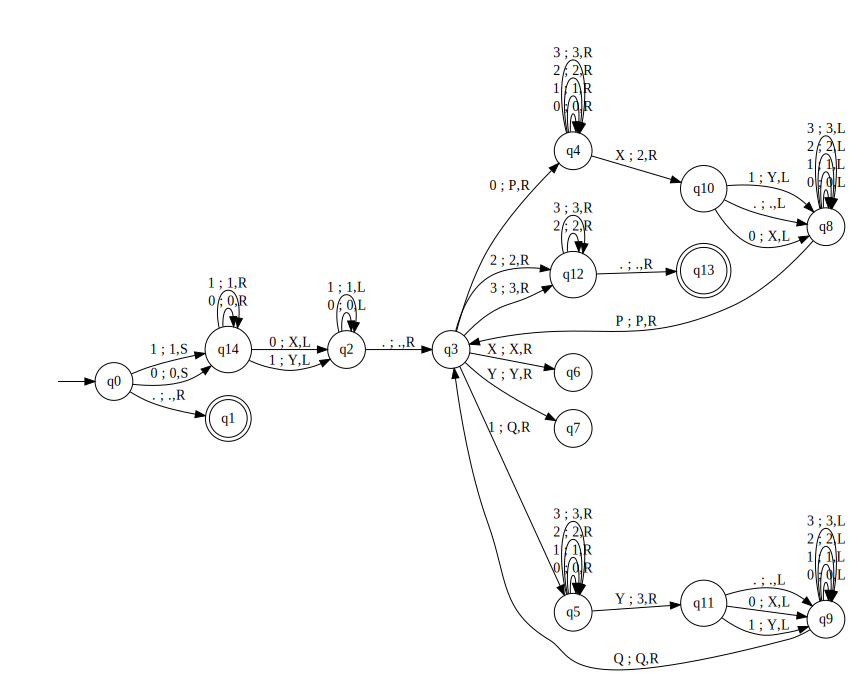

In [22]:
dotObj_tm(wwndtm)

In [23]:
wwndtmobj = dotObj_tm(wwndtm)

In [24]:
wwndtmobj.source

'// TO_St3\ndigraph {\n\tgraph [rankdir=LR]\n\t\tEMPTY [label="" shape=plaintext]\n\t\tq3 [label=q3 peripheries=1 shape=circle]\n\t\tq4 [label=q4 peripheries=1 shape=circle]\n\t\tq12 [label=q12 peripheries=1 shape=circle]\n\t\tq5 [label=q5 peripheries=1 shape=circle]\n\t\tq2 [label=q2 peripheries=1 shape=circle]\n\t\tq6 [label=q6 peripheries=1 shape=circle]\n\t\tq9 [label=q9 peripheries=1 shape=circle]\n\t\tq7 [label=q7 peripheries=1 shape=circle]\n\t\tq14 [label=q14 peripheries=1 shape=circle]\n\t\tq0 [label=q0 peripheries=1 shape=circle]\n\t\tq11 [label=q11 peripheries=1 shape=circle]\n\t\tq10 [label=q10 peripheries=1 shape=circle]\n\t\tq8 [label=q8 peripheries=1 shape=circle]\n\t\tq1 [label=q1 peripheries=2 shape=circle]\n\t\tq13 [label=q13 peripheries=2 shape=circle]\n\t\t\tEMPTY -> q0\n\t\t\tq0 -> q1 [label=". ; .,R"]\n\t\t\tq0 -> q14 [label="0 ; 0,S"]\n\t\t\tq0 -> q14 [label="1 ; 1,S"]\n\t\t\tq14 -> q14 [label="0 ; 0,R"]\n\t\t\tq14 -> q2 [label="0 ; X,L"]\n\t\t\tq14 -> q2 [label=

In [25]:
explore_tm(wwndtm, "010010", 88)

Allocating  8  tape cells to the LEFT!
Allocating  8  tape cells to the LEFT!
Allocating  8  tape cells to the LEFT!
Allocating  8  tape cells to the RIGHT!
Allocating  8  tape cells to the LEFT!
Allocating  8  tape cells to the RIGHT!
Allocating  8  tape cells to the LEFT!
Allocating  8  tape cells to the RIGHT!
Allocating  8  tape cells to the LEFT!
Detailing the halted configs now.
Rejected at  ('q4', 9, '........PY0010', 82)
 via .. 
 ->('q0', 0, '010010', 88)
 ->('q14', 0, '010010', 87)
 ->('q14', 1, '010010', 86)
 ->('q2', 0, '0Y0010', 85)
 ->('q2', 7, '........0Y0010', 84)
 ->('q3', 8, '........0Y0010', 83)
 ->('q4', 9, '........PY0010', 82)
Rejected at  ('q4', 12, '........P100Y0', 73)
 via .. 
 ->('q0', 0, '010010', 88)
 ->('q14', 0, '010010', 87)
 ->('q14', 1, '010010', 86)
 ->('q14', 2, '010010', 85)
 ->('q14', 3, '010010', 84)
 ->('q14', 4, '010010', 83)
 ->('q2', 3, '0100Y0', 82)
 ->('q2', 2, '0100Y0', 81)
 ->('q2', 1, '0100Y0', 80)
 ->('q2', 0, '0100Y0', 79)
 ->('q2', 7, 

In [26]:
explore_tm(wwndtm, "0101", 45)

Allocating  8  tape cells to the LEFT!
Allocating  8  tape cells to the LEFT!
Allocating  8  tape cells to the LEFT!
Allocating  8  tape cells to the RIGHT!
Allocating  8  tape cells to the LEFT!
Allocating  8  tape cells to the RIGHT!
Detailing the halted configs now.
Rejected at  ('q4', 9, '........PY01', 39)
 via .. 
 ->('q0', 0, '0101', 45)
 ->('q14', 0, '0101', 44)
 ->('q14', 1, '0101', 43)
 ->('q2', 0, '0Y01', 42)
 ->('q2', 7, '........0Y01', 41)
 ->('q3', 8, '........0Y01', 40)
 ->('q4', 9, '........PY01', 39)
Rejected at  ('q4', 11, '........P10Y', 33)
 via .. 
 ->('q0', 0, '0101', 45)
 ->('q14', 0, '0101', 44)
 ->('q14', 1, '0101', 43)
 ->('q14', 2, '0101', 42)
 ->('q14', 3, '0101', 41)
 ->('q2', 2, '010Y', 40)
 ->('q2', 1, '010Y', 39)
 ->('q2', 0, '010Y', 38)
 ->('q2', 7, '........010Y', 37)
 ->('q3', 8, '........010Y', 36)
 ->('q4', 9, '........P10Y', 35)
 ->('q4', 10, '........P10Y', 34)
 ->('q4', 11, '........P10Y', 33)
Rejected at  ('q14', 4, '0101', 40)
 via .. 
 ->('q0'

In [27]:
explore_tm(wwndtm, "0100101001", 666)

Allocating  8  tape cells to the LEFT!
Allocating  8  tape cells to the LEFT!
Allocating  8  tape cells to the LEFT!
Allocating  8  tape cells to the LEFT!
Allocating  8  tape cells to the LEFT!
Allocating  8  tape cells to the RIGHT!
Allocating  8  tape cells to the LEFT!
Allocating  8  tape cells to the RIGHT!
Allocating  8  tape cells to the LEFT!
Allocating  8  tape cells to the LEFT!
Allocating  8  tape cells to the RIGHT!
Allocating  8  tape cells to the LEFT!
Allocating  8  tape cells to the LEFT!
Detailing the halted configs now.
Rejected at  ('q4', 9, '........PY00101001', 660)
 via .. 
 ->('q0', 0, '0100101001', 666)
 ->('q14', 0, '0100101001', 665)
 ->('q14', 1, '0100101001', 664)
 ->('q2', 0, '0Y00101001', 663)
 ->('q2', 7, '........0Y00101001', 662)
 ->('q3', 8, '........0Y00101001', 661)
 ->('q4', 9, '........PY00101001', 660)
Rejected at  ('q4', 12, '........P100Y01001', 651)
 via .. 
 ->('q0', 0, '0100101001', 666)
 ->('q14', 0, '0100101001', 665)
 ->('q14', 1, '0100101

In [28]:
explore_tm(wwndtm, "0100101001", 666)

Allocating  8  tape cells to the LEFT!
Allocating  8  tape cells to the LEFT!
Allocating  8  tape cells to the LEFT!
Allocating  8  tape cells to the LEFT!
Allocating  8  tape cells to the LEFT!
Allocating  8  tape cells to the RIGHT!
Allocating  8  tape cells to the LEFT!
Allocating  8  tape cells to the RIGHT!
Allocating  8  tape cells to the LEFT!
Allocating  8  tape cells to the LEFT!
Allocating  8  tape cells to the RIGHT!
Allocating  8  tape cells to the LEFT!
Allocating  8  tape cells to the LEFT!
Detailing the halted configs now.
Rejected at  ('q4', 9, '........PY00101001', 660)
 via .. 
 ->('q0', 0, '0100101001', 666)
 ->('q14', 0, '0100101001', 665)
 ->('q14', 1, '0100101001', 664)
 ->('q2', 0, '0Y00101001', 663)
 ->('q2', 7, '........0Y00101001', 662)
 ->('q3', 8, '........0Y00101001', 661)
 ->('q4', 9, '........PY00101001', 660)
Rejected at  ('q4', 12, '........P100Y01001', 651)
 via .. 
 ->('q0', 0, '0100101001', 666)
 ->('q14', 0, '0100101001', 665)
 ->('q14', 1, '0100101

In [29]:
explore_tm(wwndtm, "0100101001", 66)

Allocating  8  tape cells to the LEFT!
Allocating  8  tape cells to the LEFT!
Allocating  8  tape cells to the LEFT!
Allocating  8  tape cells to the LEFT!
Allocating  8  tape cells to the LEFT!
Allocating  8  tape cells to the RIGHT!
Allocating  8  tape cells to the LEFT!
Allocating  8  tape cells to the RIGHT!
Allocating  8  tape cells to the LEFT!
Allocating  8  tape cells to the LEFT!
Allocating  8  tape cells to the LEFT!
Allocating  8  tape cells to the LEFT!
There are still  1 truncated paths.
Detailing the halted configs now.
Rejected at  ('q4', 9, '........PY00101001', 60)
 via .. 
 ->('q0', 0, '0100101001', 66)
 ->('q14', 0, '0100101001', 65)
 ->('q14', 1, '0100101001', 64)
 ->('q2', 0, '0Y00101001', 63)
 ->('q2', 7, '........0Y00101001', 62)
 ->('q3', 8, '........0Y00101001', 61)
 ->('q4', 9, '........PY00101001', 60)
Rejected at  ('q4', 12, '........P100Y01001', 51)
 via .. 
 ->('q0', 0, '0100101001', 66)
 ->('q14', 0, '0100101001', 65)
 ->('q14', 1, '0100101001', 64)
 ->('

In [30]:
addtm = {
    # This TM adds two numbers in base 2.
    #
    # Input: matches the regex "[01][01]*\+[01][01]*"
    #        Interpreted as a+b where a and b are unsigned integers in big-endian
    #          form
    # Output: Occurs on a halt in the "done" state.
    #         The sum of the numbers in big endian form.
    #         No other characters will be on the tape.
    #         There willbe no leading zeros on the answer.
    # Errors: The only errors that can occur are input errors which lead to
    #           a halt on the "error" state. This indicates the input does
    #           not conform to the input requirement.
    # Detail: There is no length maximums on the input.
    #         The numbers can be of different lengths.
    #         Leading zeros on inputs only cause a longer runtime.
    "Q": {
        # final states
        "done", "error",

        # input validation states
        "start",
        "check_a",
        "check_b_start",
        "check_b",

        # adder states
        "read_next_b_digit",
        "0_scan_to_a",
        "1_scan_to_a",
        "n_scan_to_a",
        "0_scan_to_a_digit",
        "1_scan_to_a_digit",
        "n_scan_to_a_digit",
        "0_scan_to_output",
        "1_scan_to_output",
        "c0_scan_to_output",
        "write_carry",
        "scan_to_b",
        "scan_to_b_digit",

        # answer formatting states
        "erase_until_sum",
        "find_end_of_sum",
        "read_msb_of_sum",
        "0_check_end_of_sum",
        "1_check_end_of_sum",
        "0_write_last_digit",
        "1_write_last_digit",
        "write_last_0",
        "write_last_1",
        "0_find_end_of_sum",
        "1_find_end_of_sum",
        "0_find_answer",
        "1_find_answer",
        "write_0",
        "write_1",
        "find_start_of_sum",
        "find_start_of_answer",
        "erase_leading_zeros",
    },

    "Sigma" : {'0', '1', '+'},

    "Gamma" : {'.',
               '0', '1', '+',
               'a', # right side marker for a input
               'b', # right side marker for b input
               'c', # carry indicator
               'X', # 0 used indicator
               'Y', # 1 used indicator
               's', # left side of answer space marker
               },

    "Delta" : {
        # Begin input validation
        ("start", '.') : { ("error", '.', 'S') },
        ("start", '+') : { ("error", '.', 'S') },
        ("start", '0') : { ("check_a", '0', 'R') },
        ("start", '1') : { ("check_a", '1', 'R') },
        #
        ("check_a", '0') : { ("check_a", '0', 'R') },
        ("check_a", '1') : { ("check_a", '1', 'R') },
        ("check_a", '.') : { ("error", '.', 'S') },
        ("check_a", '+') : { ("check_b_start", 'a', 'R') },
        #
        ("check_b_start", '0') : { ("check_b", '0', 'R') },
        ("check_b_start", '1') : { ("check_b", '1', 'R') },
        ("check_b_start", '.') : { ("error", '.', 'S') },
        ("check_b_start", '+') : { ("error", '+', 'S') },
        #
        ("check_b", '0') : { ("check_b", '0', 'R') },
        ("check_b", '1') : { ("check_b", '1', 'R') },
        ("check_b", '.') : { ("read_next_b_digit", 'b', 'L') },
        ("check_b", '+') : { ("error", '+', 'S') },
        # End input validation

        # Begin adder
        ("read_next_b_digit", '0') : { ("0_scan_to_a", 'X', 'L') },
        ("read_next_b_digit", '1') : { ("1_scan_to_a", 'Y', 'L') },
        #
        ("0_scan_to_a", '0') : { ("0_scan_to_a", '0', 'L') },
        ("0_scan_to_a", '1') : { ("0_scan_to_a", '1', 'L') },
        ("0_scan_to_a", 'a') : { ("0_scan_to_a_digit", 'a', 'L') },
        #
        ("1_scan_to_a", '0') : { ("1_scan_to_a", '0', 'L') },
        ("1_scan_to_a", '1') : { ("1_scan_to_a", '1', 'L') },
        ("1_scan_to_a", 'a') : { ("1_scan_to_a_digit", 'a', 'L') },
        #
        ("n_scan_to_a", '0') : { ("n_scan_to_a", '0', 'L') },
        ("n_scan_to_a", '1') : { ("n_scan_to_a", '1', 'L') },
        ("n_scan_to_a", 'a') : { ("n_scan_to_a_digit", 'a', 'L') },
        #
        ("0_scan_to_a_digit", 'X') : { ("0_scan_to_a_digit", 'X', 'L') },
        ("0_scan_to_a_digit", 'Y') : { ("0_scan_to_a_digit", 'Y', 'L') },
        ("0_scan_to_a_digit", '0') : { ("0_scan_to_output", 'X', 'R') },
        ("0_scan_to_a_digit", '1') : { ("1_scan_to_output", 'Y', 'R') },
        ("0_scan_to_a_digit", '.') : { ("0_scan_to_output", 's', 'R') },
        ("0_scan_to_a_digit", 's') : { ("0_scan_to_output", 's', 'R') },
        #
        ("1_scan_to_a_digit", 'X') : { ("1_scan_to_a_digit", 'X', 'L') },
        ("1_scan_to_a_digit", 'Y') : { ("1_scan_to_a_digit", 'Y', 'L') },
        ("1_scan_to_a_digit", '0') : { ("1_scan_to_output", 'X', 'R') },
        ("1_scan_to_a_digit", '1') : { ("c0_scan_to_output", 'Y', 'R') },
        ("1_scan_to_a_digit", '.') : { ("1_scan_to_output", 's', 'R') },
        ("1_scan_to_a_digit", 's') : { ("1_scan_to_output", 's', 'R') },
        #
        ("n_scan_to_a_digit", 'X') : { ("n_scan_to_a_digit", 'X', 'L') },
        ("n_scan_to_a_digit", 'Y') : { ("n_scan_to_a_digit", 'Y', 'L') },
        ("n_scan_to_a_digit", '0') : { ("0_scan_to_output", 'X', 'R') },
        ("n_scan_to_a_digit", '1') : { ("1_scan_to_output", 'Y', 'R') },
        ("n_scan_to_a_digit", '.') : { ("erase_until_sum", 's', 'R') },
        ("n_scan_to_a_digit", 's') : { ("erase_until_sum", 's', 'R') },
        #
        ("0_scan_to_output", '0') : { ("0_scan_to_output", '0', 'R') },
        ("0_scan_to_output", '1') : { ("0_scan_to_output", '1', 'R') },
        ("0_scan_to_output", 'X') : { ("0_scan_to_output", 'X', 'R') },
        ("0_scan_to_output", 'Y') : { ("0_scan_to_output", 'Y', 'R') },
        ("0_scan_to_output", 'a') : { ("0_scan_to_output", 'a', 'R') },
        ("0_scan_to_output", 'b') : { ("0_scan_to_output", 'b', 'R') },
        ("0_scan_to_output", '.') : { ("scan_to_b", '0', 'L') },
        ("0_scan_to_output", 'c') : { ("scan_to_b", '1', 'L') },
        #
        ("1_scan_to_output", '0') : { ("1_scan_to_output", '0', 'R') },
        ("1_scan_to_output", '1') : { ("1_scan_to_output", '1', 'R') },
        ("1_scan_to_output", 'X') : { ("1_scan_to_output", 'X', 'R') },
        ("1_scan_to_output", 'Y') : { ("1_scan_to_output", 'Y', 'R') },
        ("1_scan_to_output", 'a') : { ("1_scan_to_output", 'a', 'R') },
        ("1_scan_to_output", 'b') : { ("1_scan_to_output", 'b', 'R') },
        ("1_scan_to_output", '.') : { ("scan_to_b", '1', 'L') },
        ("1_scan_to_output", 'c') : { ("write_carry", '0', 'R') },
        #
        ("c0_scan_to_output", '0') : { ("c0_scan_to_output", '0', 'R') },
        ("c0_scan_to_output", '1') : { ("c0_scan_to_output", '1', 'R') },
        ("c0_scan_to_output", 'X') : { ("c0_scan_to_output", 'X', 'R') },
        ("c0_scan_to_output", 'Y') : { ("c0_scan_to_output", 'Y', 'R') },
        ("c0_scan_to_output", 'a') : { ("c0_scan_to_output", 'a', 'R') },
        ("c0_scan_to_output", 'b') : { ("c0_scan_to_output", 'b', 'R') },
        ("c0_scan_to_output", '.') : { ("write_carry", '0', 'R') },
        ("c0_scan_to_output", 'c') : { ("write_carry", '1', 'R') },
        #
        ("write_carry", '.') : { ("scan_to_b", 'c', 'L') },
        #
        ("scan_to_b", '0') : { ("scan_to_b", '0', 'L') },
        ("scan_to_b", '1') : { ("scan_to_b", '1', 'L') },
        ("scan_to_b", 'b') : { ("scan_to_b_digit", 'b', 'L') },
        #
        ("scan_to_b_digit", 'X') : { ("scan_to_b_digit", 'X', 'L') },
        ("scan_to_b_digit", 'Y') : { ("scan_to_b_digit", 'Y', 'L') },
        ("scan_to_b_digit", '0') : { ("read_next_b_digit", '0', 'S') },
        ("scan_to_b_digit", '1') : { ("read_next_b_digit", '1', 'S') },
        ("scan_to_b_digit", 'a') : { ("n_scan_to_a", 'a', 'S') },
        # End adder

        # Begin answer formatting
        ("erase_until_sum", '0') : { ("erase_until_sum", '.', 'R') },
        ("erase_until_sum", '1') : { ("erase_until_sum", '.', 'R') },
        ("erase_until_sum", 'X') : { ("erase_until_sum", '.', 'R') },
        ("erase_until_sum", 'Y') : { ("erase_until_sum", '.', 'R') },
        ("erase_until_sum", 'a') : { ("erase_until_sum", '.', 'R') },
        ("erase_until_sum", 'b') : { ("find_end_of_sum", '.', 'R') },
        #
        ("find_end_of_sum", '0') : { ("find_end_of_sum", '0', 'R') },
        ("find_end_of_sum", '1') : { ("find_end_of_sum", '1', 'R') },
        ("find_end_of_sum", 'c') : { ("read_msb_of_sum", '1', 'S') },
        ("find_end_of_sum", '.') : { ("read_msb_of_sum", '.', 'L') },
        #
        ("read_msb_of_sum", '0') : { ("0_check_end_of_sum", '.', 'L') },
        ("read_msb_of_sum", '1') : { ("1_check_end_of_sum", '.', 'L') },
        #
        ("0_check_end_of_sum", '0') : { ("0_find_end_of_sum", '0', 'L') },
        ("0_check_end_of_sum", '1') : { ("0_find_end_of_sum", '1', 'L') },
        ("0_check_end_of_sum", '.') : { ("0_write_last_digit", '.', 'L') },
        #
        ("1_check_end_of_sum", '0') : { ("1_find_end_of_sum", '0', 'L') },
        ("1_check_end_of_sum", '1') : { ("1_find_end_of_sum", '1', 'L') },
        ("1_check_end_of_sum", '.') : { ("1_write_last_digit", '.', 'L') },
        #
        ("0_write_last_digit", '.') : { ("0_write_last_digit", '.', 'L') },
        ("0_write_last_digit", '0') : { ("write_last_0", '0', 'R') },
        ("0_write_last_digit", '1') : { ("write_last_0", '1', 'R') },
        ("0_write_last_digit", 's') : { ("write_last_0", '.', 'R') },
        #
        ("1_write_last_digit", '.') : { ("1_write_last_digit", '.', 'L') },
        ("1_write_last_digit", '0') : { ("write_last_1", '0', 'R') },
        ("1_write_last_digit", '1') : { ("write_last_1", '1', 'R') },
        ("1_write_last_digit", 's') : { ("write_last_1", '.', 'R') },
        #
        ("write_last_0", '.') : { ("find_start_of_answer", '0', 'S') },
        #
        ("write_last_1", '.') : { ("find_start_of_answer", '1', 'S') },
        #
        ("0_find_end_of_sum", '0') : { ("0_find_end_of_sum", '0', 'L') },
        ("0_find_end_of_sum", '1') : { ("0_find_end_of_sum", '1', 'L') },
        ("0_find_end_of_sum", '.') : { ("0_find_answer", '.', 'L') },
        #
        ("1_find_end_of_sum", '0') : { ("1_find_end_of_sum", '0', 'L') },
        ("1_find_end_of_sum", '1') : { ("1_find_end_of_sum", '1', 'L') },
        ("1_find_end_of_sum", '.') : { ("1_find_answer", '.', 'L') },
        #
        ("0_find_answer", '.') : { ("0_find_answer", '.', 'L') },
        ("0_find_answer", '0') : { ("write_0", '0', 'R') },
        ("0_find_answer", '1') : { ("write_0", '1', 'R') },
        ("0_find_answer", 's') : { ("write_0", '.', 'R') },
        #
        ("1_find_answer", '.') : { ("1_find_answer", '.', 'L') },
        ("1_find_answer", '0') : { ("write_1", '0', 'R') },
        ("1_find_answer", '1') : { ("write_1", '1', 'R') },
        ("1_find_answer", 's') : { ("write_1", '.', 'R') },
        #
        ("write_0", '.') : { ("find_start_of_sum", '0', 'R') },
        #
        ("write_1", '.') : { ("find_start_of_sum", '1', 'R') },
        #
        ("find_start_of_sum", '.') : { ("find_start_of_sum", '.', 'R') },
        ("find_start_of_sum", '0') : { ("find_end_of_sum", '0', 'S') },
        ("find_start_of_sum", '1') : { ("find_end_of_sum", '1', 'S') },
        #
        ("find_start_of_answer", '0') : { ("find_start_of_answer", '0', 'L') },
        ("find_start_of_answer", '1') : { ("find_start_of_answer", '1', 'L') },
        ("find_start_of_answer", '.') : { ("erase_leading_zeros", '.', 'R') },
        #
        ("erase_leading_zeros", '0') : { ("erase_leading_zeros", '.', 'R') },
        ("erase_leading_zeros", '1') : { ("done", '1', 'S') },
        ("erase_leading_zeros", '.') : { ("done", '0', 'S') },
        # End answer formatting
    },

    "q0"    : "start",

    "B"     : '.',

    "F"     : {"done"}
}

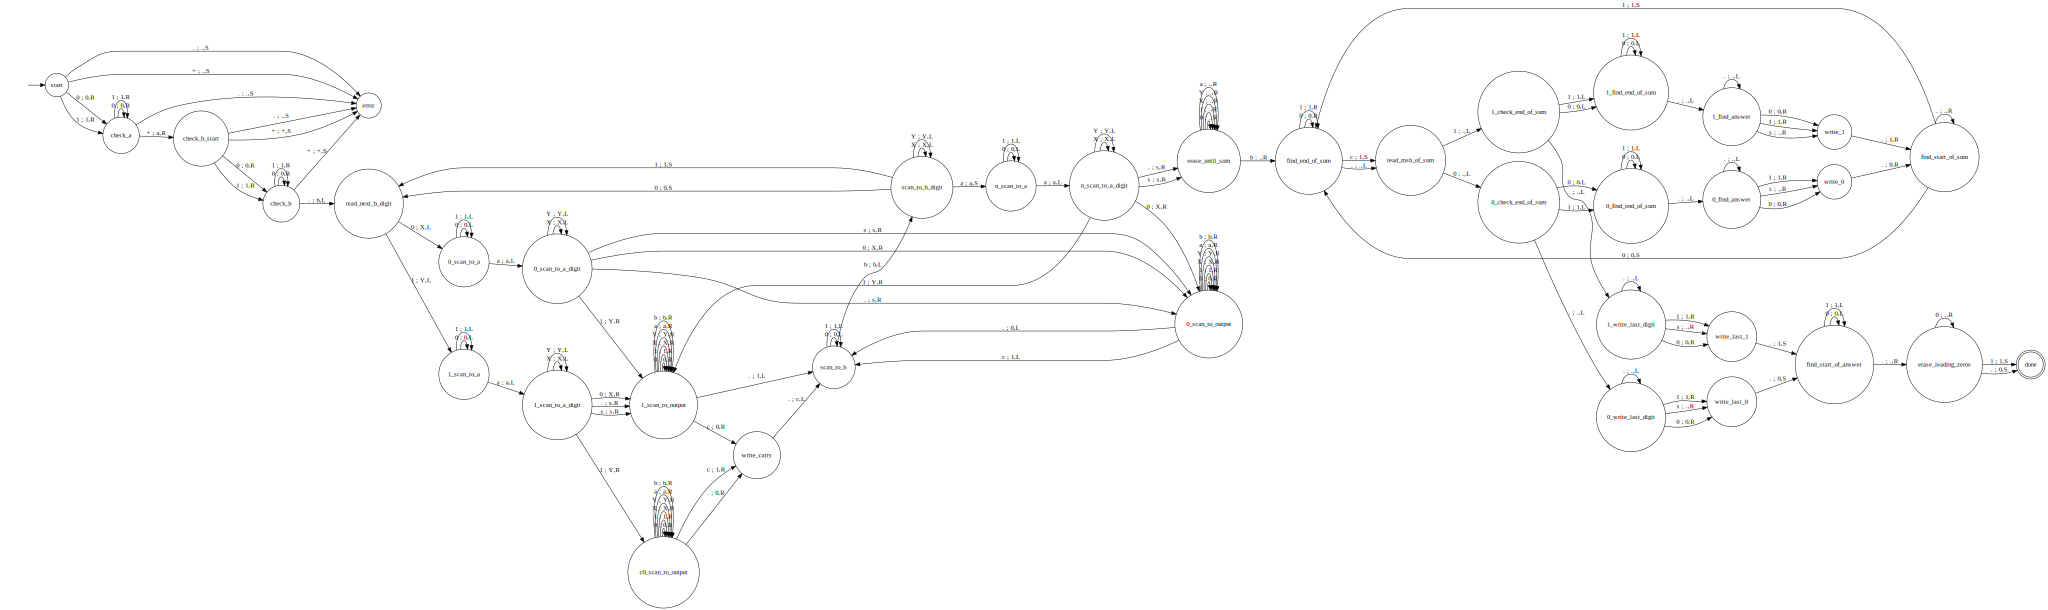

In [31]:
dotObj_tm(addtm)

In [32]:
addtmobj = dotObj_tm(addtm)

In [33]:
addtmobj.source

'// TO_St5\ndigraph {\n\tgraph [rankdir=LR]\n\t\tEMPTY [label="" shape=plaintext]\n\t\t"1_scan_to_a_digit" [label="1_scan_to_a_digit" peripheries=1 shape=circle]\n\t\terase_leading_zeros [label=erase_leading_zeros peripheries=1 shape=circle]\n\t\twrite_0 [label=write_0 peripheries=1 shape=circle]\n\t\t"0_check_end_of_sum" [label="0_check_end_of_sum" peripheries=1 shape=circle]\n\t\tstart [label=start peripheries=1 shape=circle]\n\t\t"0_scan_to_a_digit" [label="0_scan_to_a_digit" peripheries=1 shape=circle]\n\t\t"0_scan_to_a" [label="0_scan_to_a" peripheries=1 shape=circle]\n\t\twrite_carry [label=write_carry peripheries=1 shape=circle]\n\t\t"1_find_answer" [label="1_find_answer" peripheries=1 shape=circle]\n\t\tscan_to_b [label=scan_to_b peripheries=1 shape=circle]\n\t\t"1_scan_to_a" [label="1_scan_to_a" peripheries=1 shape=circle]\n\t\twrite_last_0 [label=write_last_0 peripheries=1 shape=circle]\n\t\terror [label=error peripheries=1 shape=circle]\n\t\t"1_check_end_of_sum" [label="1_ch

In [34]:
explore_tm(addtm, "11111101+11111101", 735)

Allocating  8  tape cells to the RIGHT!
Allocating  8  tape cells to the RIGHT!
Allocating  8  tape cells to the LEFT!
Detailing the halted configs now.
Accepted at  ('done', 8, '........111111010........................', 2)
 via .. 
 ->('start', 0, '11111101+11111101', 735)
 ->('check_a', 1, '11111101+11111101', 734)
 ->('check_a', 2, '11111101+11111101', 733)
 ->('check_a', 3, '11111101+11111101', 732)
 ->('check_a', 4, '11111101+11111101', 731)
 ->('check_a', 5, '11111101+11111101', 730)
 ->('check_a', 6, '11111101+11111101', 729)
 ->('check_a', 7, '11111101+11111101', 728)
 ->('check_a', 8, '11111101+11111101', 727)
 ->('check_b_start', 9, '11111101a11111101', 726)
 ->('check_b', 10, '11111101a11111101', 725)
 ->('check_b', 11, '11111101a11111101', 724)
 ->('check_b', 12, '11111101a11111101', 723)
 ->('check_b', 13, '11111101a11111101', 722)
 ->('check_b', 14, '11111101a11111101', 721)
 ->('check_b', 15, '11111101a11111101', 720)
 ->('check_b', 16, '11111101a11111101', 719)
 ->('c